<a href="https://colab.research.google.com/github/mabelc/forcasting/blob/master/notebooks/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA

ARIMA, acronym of ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors. ARIMA models aim to describe the autocorrelations in the data.

## Data transformation

If the data show variation that increases or decreases with the level of the series, then a transformation can be useful. A useful family of transformations, that includes both logarithms and power transformations, is the family of Box-Cox transformations, which depend on the parameter $\lambda$ and are defined as follows:

* $\lambda=0, w_t=log( y_t)$
* $\lambda\neq0, w_t=(y^\lambda_t-1)/\lambda$

A good value of $\lambda$ is one which makes the size of the seasonal variation about the same across the whole series, as that makes the forecasting model simpler.

We will find the best $\lambda$ to transform Australian monthly electricity production:

In [1]:
!pip install tscv

In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 7.5MB/s 
     |████████████████████████████████| 8.7MB 46.6MB/s 
     |████████████████████████████████| 2.1MB 47.1MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.19
    Uninstalling Cython-0.29.19:
      Successfully uninstalled Cython-0.29.19


In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tscv
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from tscv import GapWalkForward
from rpy2.robjects import pandas2ri, r
from scipy.stats import boxcox
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [0]:
# install fpp2 package
utils = importr('utils')
utils.install_packages('fpp2')

In [5]:
# get the data and create dataframe
ro.r('library(fpp2)')
elec_np = r('elec')
elec_df = pd.DataFrame(elec_np, index=pd.date_range(start='1/1/1956',  periods=476, freq='M'), columns=['production'])

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: forecast

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Loading required package: fma

R[write to console]: Loading required package: expsmooth



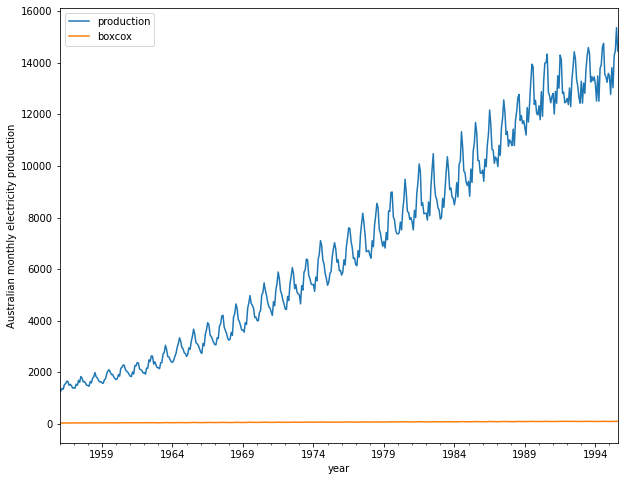

In [67]:
# plot data
elec_df.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('Australian monthly electricity production')
plt.show()

The data show variation that increases with the years. We use the function **boxcox** to transform the data:

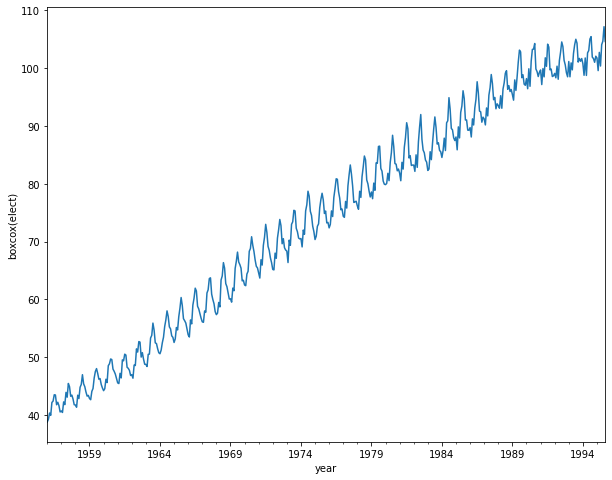

Lambda value is:  0.3896252316581785


In [68]:
# estimate lambda and transform the data
elec_transf = boxcox(elec_df.production)
elec_df['boxcox'] = elec_transf[0]

# plot data
elec_df.boxcox.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('boxcox(elect)')
plt.show()

print('Lambda value is: ', elec_transf[1])

## Non-Seasonal ARIMA models

 ARIMA models combine differencing, autoregresion and moving average model. The full model can be written as:

 $y^{'}_{t}=c+\phi_{1} y^{'}_{t-1}+...+\phi_{p} y^{'}_{t-p}+\theta_{1} \epsilon_{t-1} +...+ \theta_{q} \epsilon_{t-q}+\epsilon_{t}$

 Where $y^{'}_{t}$ is the differenced series. This model is called ARIMA($p,d,q$) model where:

 * $p$ = order of the autoregressive part
 * $d$ = degree of first differencing involved
 * $q$ = order of the moving average part

We will use the quarterly percentage changes in US consumption expenditure to fit a non-seasonal ARIMA. 

In [0]:
# get the data and create dataframe

us_np = r('uschange[,"Consumption"]')
index= pd.date_range(start='1970', end='2017', freq='Q')[0:-1]
us_df = pd.DataFrame(us_np, index)
us_df.columns = ['consumption']

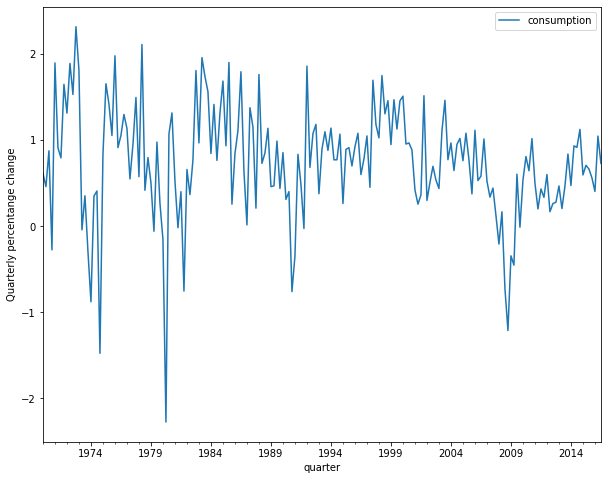

In [70]:
# plot data
us_df.plot(figsize=(10,8))
plt.xlabel('quarter')
plt.ylabel('Quarterly percentange change')
plt.show()

Pmdarima package brings R's auto.arima functionality to Python by wrapping statsmodel ARIMA and SARIMAX models. We will search the best model by minimizing the Akaike Information Criterion. We define the search range of the parameters $p$ and $q$.

In [71]:
# fitting a stepwise model:
stepwise_fit = auto_arima(us_df.consumption, start_p=1, start_q=1, max_p=3, max_q=3, m=4,
                             seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             information_criterion='aicc', # optimize aicc
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aicc
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=343.815, BIC=356.740, Time=0.127 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=375.632, BIC=382.095, Time=0.042 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=353.332, BIC=363.025, Time=0.052 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=360.371, BIC=370.064, Time=0.126 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=529.744, BIC=532.975, Time=0.023 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=344.493, BIC=360.649, Time=0.163 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=343.330, BIC=359.485, Time=0.139 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=356.797, BIC=369.721, Time=0.080 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=342.284, BIC=361.671, Time=0.255 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=342.536, BIC=365.154, Time=0.299 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=343.17

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -164.807
Date:                Fri, 05 Jun 2020   AIC                            341.613
Time:                        10:07:01   BIC                            361.000
Sample:                             0   HQIC                           349.469
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3066      0.096      3.199      0.001       0.119       0.494
ar.L1          0.5887      0.132      4.458      0.000       0.330       0.847
ma.L1         -0.3529      0.138     -2.552      0.011      -0.624      -0.082
ma.L2          0.0846      0.065      1.309      0.190      -0.042       0.211
ma.L3          0.1738      0.079      2.214      0.027       0.020       0.328
sigma2         0.3405      0.025     13.646      0.000       0.292       0.389
===================================================================================
Ljung-Box (Q):                       41.41   Jarque-Bera (JB):                64.65
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model found is ARIMA(1,0,3). Attending the parameters provided (**intercept**, **ar.L1**, **ma.L1**, **ma.L2**, **ma.L3**), the model can be expressed as:

$y^{'}_{t}= 0.307 + 0.589 y^{'}_{t-1}-0.353 \epsilon_{t-1} +0.085\epsilon_{t-2} + 0.174 \epsilon_{t-3}+\epsilon_{t}$

If we know in advance the parameters, we can call directly the function _ARIMA_ from the package **statsmodels**.

In [72]:
# fit ARIMA model

arima_model = ARIMA(us_df.consumption, order=(1,0,3))
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            consumption   No. Observations:                  187
Model:                     ARMA(1, 3)   Log Likelihood                -164.807
Method:                       css-mle   S.D. of innovations              0.584
Date:                Fri, 05 Jun 2020   AIC                            341.613
Time:                        10:07:06   BIC                            361.000
Sample:                    03-31-1970   HQIC                           349.469
                         - 09-30-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7454      0.093      8.011      0.000       0.563       0.928
ar.L1.consumption     0.5885      0.154      3.817      0.000       0.286       0.891
ma.L1.consumption    -0.3528      0.166     -2.128      0.033      -0.678      -0.028
ma.L2.consumption     0.0846      0.082      1.033      0.301      -0.076       0.245
ma.L3.consumption     0.1739      0.084      2.062      0.039       0.009       0.339
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6991           +0.0000j            1.6991            0.0000
MA.1            0.9410           -1.2421j            1.5583           -0.1468
MA.2            0.9410           +1.2421j            1.5583            0.1468
MA.3           -2.3683           -0.0000j            2.3683           -0.5000
-----------------------------------------------------------------------------
"""

We predict future values as usual.

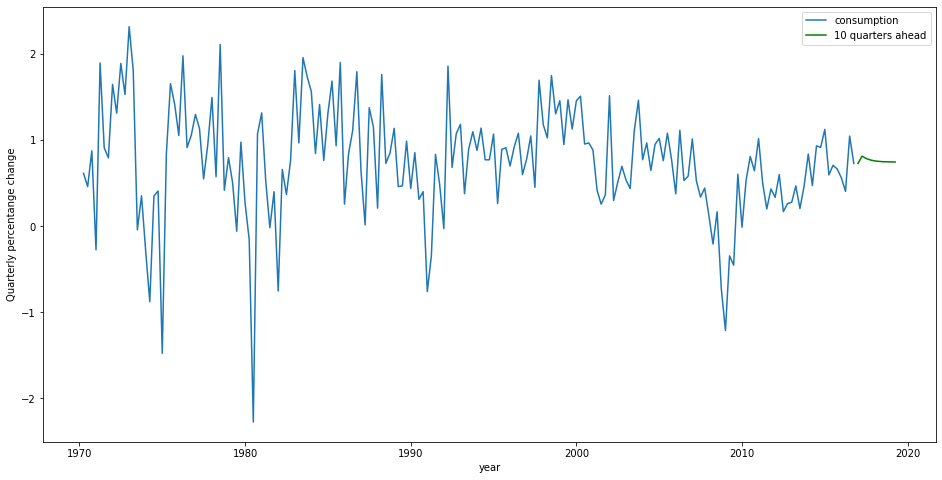

In [73]:
# predicting the next 10 values

predict_arima = arima_fit.forecast(10)[0]
predict_arima

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(us_df.index, us_df.consumption.values, label='consumption')
ax.plot(pd.date_range(start='31/12/2016',  periods=10, freq='Q'), predict_arima, color="green", label='10 quarters ahead')
plt.ylabel('Quarterly percentange change') 
plt.xlabel('year') 
plt.legend();

The function **auto_arima** does not consider all possible models in its search. We can make it work harder by using the argument _stepwise_=FALSE. However, the stepwise algorithm can be significantly faster than fitting all hyper-parameter combinations and is less likely to over-fit the model so it would be our first choice. 

In [74]:
# fitting a grid search model:
grid_fit = auto_arima(us_df.consumption, start_p=1, start_q=1, max_p=3, max_q=3, m=4,
                             seasonal=False, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             information_criterion='aicc', # optimize aicc
                             stepwise=False)  # set to stepwise

grid_fit.summary()

Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=375.632, BIC=382.095, Time=0.038 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=360.371, BIC=370.064, Time=0.126 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=356.797, BIC=369.721, Time=0.078 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=342.758, BIC=358.914, Time=0.099 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=353.332, BIC=363.025, Time=0.050 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=343.815, BIC=356.740, Time=0.116 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=343.330, BIC=359.485, Time=0.135 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=341.613, BIC=361.000, Time=0.159 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=346.268, BIC=359.192, Time=0.074 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=344.493, BIC=360.649, Time=0.164 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=342.284, BIC=361.671, Time=0.267 seconds
Fit ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -165.170
Date:                Fri, 05 Jun 2020   AIC                            340.340
Time:                        10:07:16   BIC                            356.495
Sample:                             0   HQIC                           346.886
                                - 187                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3050      0.062      4.889      0.000       0.183       0.427
ar.L1          0.2275      0.058      3.946      0.000       0.114       0.340
ar.L2          0.1604      0.059      2.721      0.007       0.045       0.276
ar.L3          0.2027      0.067      3.025      0.002       0.071       0.334
sigma2         0.3419      0.024     13.957      0.000       0.294       0.390
===================================================================================
Ljung-Box (Q):                       40.42   Jarque-Bera (JB):                63.29
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model found now ARIMA(3,0,0) is slightly better than the previous one, attending to the AIC.

## Check the residuals

It is recommended to check if the residuals behave like white noise. If not the model is not considered good enough and we need to try a better adjustment.

We will check the residuals from the model fitted in the last section.

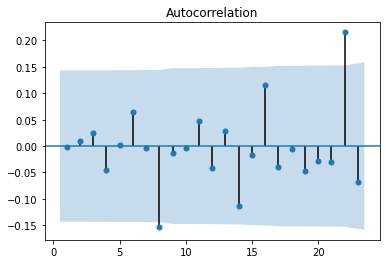

In [75]:
# ACF plot

plot_acf(stepwise_fit.resid(), zero=False)
plt.show()

The ACF plot shows that almost all autocorrelations are within the threshold limits except at 8 and 22 lags.

Ljung-Box test helps to determine if the residuals can be considered as white noise.

In [76]:
acorr_ljungbox(stepwise_fit.resid(), lags=22)[1]

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


array([0.97618924, 0.99054391, 0.98713647, 0.97073785, 0.99101314,
       0.97017102, 0.98760461, 0.65704429, 0.74560877, 0.8198778 ,
       0.84671067, 0.87441726, 0.9065956 , 0.79398497, 0.84327608,
       0.71514154, 0.75402208, 0.80683873, 0.82790721, 0.86076303,
       0.88777361, 0.37334601])

Ljung-Box test returns large p-values for all lags tested, also suggesting that the residuals are white noise.

## Seasonal ARIMA models

ARIMA models are also capable of modelling a wide range of seasonal data. A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA:

ARIMA(p,d,q)(P,D,Q)m

where m = number of observations per year. The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

We will fit a seasonal ARIMA model using quarterly European retail trade data from 1996 to 2011.

In [0]:
# get the data and create dataframe

eu_np = r('euretail')
index= pd.date_range(start='1996', end='2012', freq='Q')
eu_df = pd.DataFrame(eu_np, index)
eu_df.columns = ['retail']

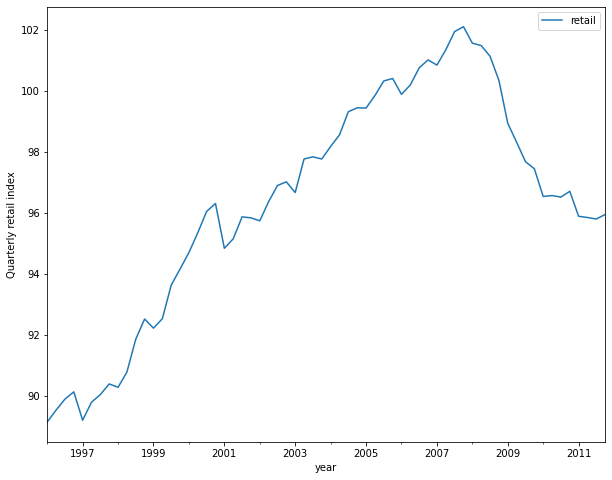

In [78]:
# plot data

eu_df.plot(figsize=(10,8))
plt.xlabel('year')
plt.ylabel('Quarterly retail index')
plt.show()

Now, we will find the best ARIMA model.

In [79]:
# fitting a grid search model:
eu_fit_p = auto_arima(eu_df.retail, start_p=0, start_q=0, max_p=3, max_q=3, m=4,
                          seasonal=True, trace=True, start_P=0, max_P=3,
                          start_Q=0, max_Q=3,
                          information_criterion='aicc', # optimize by aicc
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=False)  # set to stepwise

eu_fit_p.summary()

Fit ARIMA(0,2,0)x(0,0,0,4) [intercept=True]; AIC=127.888, BIC=132.142, Time=0.040 seconds
Fit ARIMA(0,2,0)x(0,0,1,4) [intercept=True]; AIC=122.289, BIC=128.670, Time=0.044 seconds
Fit ARIMA(0,2,0)x(0,0,2,4) [intercept=True]; AIC=108.684, BIC=117.192, Time=0.082 seconds
Fit ARIMA(0,2,0)x(0,0,3,4) [intercept=True]; AIC=110.010, BIC=120.646, Time=0.239 seconds
Fit ARIMA(0,2,0)x(1,0,0,4) [intercept=True]; AIC=113.800, BIC=120.181, Time=0.051 seconds
Fit ARIMA(0,2,0)x(1,0,1,4) [intercept=True]; AIC=96.691, BIC=105.200, Time=0.288 seconds
Fit ARIMA(0,2,0)x(1,0,2,4) [intercept=True]; AIC=98.605, BIC=109.241, Time=0.488 seconds
Fit ARIMA(0,2,0)x(1,0,3,4) [intercept=True]; AIC=98.599, BIC=111.362, Time=0.746 seconds
Fit ARIMA(0,2,0)x(2,0,0,4) [intercept=True]; AIC=101.061, BIC=109.569, Time=0.108 seconds
Fit ARIMA(0,2,0)x(2,0,1,4) [intercept=True]; AIC=98.576, BIC=109.211, Time=0.621 seconds
Fit ARIMA(0,2,0)x(2,0,2,4) [intercept=True]; AIC=97.829, BIC=110.592, Time=0.617 seconds
Fit ARIMA(0,2,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 4)   Log Likelihood                 -33.152
Date:                           Fri, 05 Jun 2020   AIC                             78.304
Time:                                   10:08:23   BIC                             91.066
Sample:                                        0   HQIC                            83.315
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.025e-05      0.000     -0.225      0.822      -0.000       0.000
ar.L1          0.3540      0.131      2.696      0.007       0.097       0.611
ma.L1         -0.9897      0.057    -17.501      0.000      -1.101      -0.879
ar.S.L4        0.9934      0.028     35.597      0.000       0.939       1.048
ma.S.L4       -0.8867      0.245     -3.616      0.000      -1.367      -0.406
sigma2         0.1522      0.032      4.739      0.000       0.089       0.215
===================================================================================
Ljung-Box (Q):                       27.72   Jarque-Bera (JB):                 3.29
Prob(Q):                              0.93   Prob(JB):                         0.19
Heteroskedasticity (H):               0.52   Skew:                            -0.32
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model found ARIMA(1,2,1)(1,0,1)4 differs from the model reported in https://otexts.com/fpp2/seasonal-arima.html (ARIMA(0,1,3)(0,1,1)4). The parameters of differencing used in Python, during the search, are: d=2 and D=0. The best model uses d=0 and D=1 instead. We call the R code to get the best combination reported for this problem.

In [80]:
ro.r('library(forecast)')
ro.r('print(auto.arima(euretail))')

Series: euretail 
ARIMA(0,1,3)(0,1,1)[4] 

Coefficients:
         ma1     ma2     ma3     sma1
      0.2630  0.3694  0.4200  -0.6636
s.e.  0.1237  0.1255  0.1294   0.1545

sigma^2 estimated as 0.156:  log likelihood=-28.63
AIC=67.26   AICc=68.39   BIC=77.65


coef,[ 0.26301544 0.36941344 0.4200241 -0.66356733]
sigma2,[0.1559738]
var.coef,[[0.01529001 0.00189766 0.00591913 0.00475293] [0.00189766 0.01575946 0.00372692 0.00611093] [0.00591913 0.00372692 0.01674556 0.00277485] [0.00475293 0.00611093 0.00277485 0.02387971]]
...,...
aicc,[68.39030593]
x,[ 89.13 89.52 89.88 90.12 89.19 89.78 90.03 90.38 90.27 90.77 91.85 92.51 92.21 92.52 93.62 94.15 94.69 95.34 96.04 96.3 94.83 95.14 95.86 95.83 95.73 96.36 96.89 97.01 96.66 97.76 97.83 97.76 98.17 98.55 99.31 99.44 99.43 99.84 100.32 100.4 99.88 100.19 100.75 101.01 100.84 101.34 101.94 102.1 101.56 101.48 101.13 100.34 98.93 98.31 97.67 97.44 96.53 96.56 96.51 96.7 95.88 95.84 95.79 95.94]
fitted,[ 89.07854079 89.49668468 89.86443234 90.14335196 89.38035266 89.63806221 90.14418514 90.30381762 89.68053704 90.91929006 91.30728251 92.46077462 92.17363257 92.9357279 93.09185025 94.06269092 93.80189778 95.6075584 96.44165278 96.67241896 95.86092066 94.75884948 95.47437475 96.06782847 95.51652971 96.29937851 97.10752522 97.19572447 96.5071729 97.04503345 98.60285133 98.16185574 97.28763564 98.63436029 99.15738676 99.803163 99.25095492 100.00259003 100.28004952 100.46491534 100.25003491 100.30856382 100.53401314 100.71367461 100.89026718 101.48498926 101.95392168 102.01952349 101.84684762 101.9805776 101.84044407 100.79631167 99.42738459 98.61858496 98.11010349 97.07077455 96.55826608 96.45554542 96.68710915 96.30620817 96.0202242 95.91197544 95.88798492 95.62061956]


This new model shows a best value of AIC=67.26 in compare with the AIC=78.30 obtained previously. Now we fit this model using the Python SARIMAX function from the package **statsmodels**:

In [81]:
# create the seasonal arima model

arima_model = SARIMAX(eu_df.retail, order=(0,1,3), seasonal_order=(0,1,1,4))
eu_fit_r = arima_model.fit()
eu_fit_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              retail   No. Observations:                   64
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 4)   Log Likelihood                 -28.632
Date:                             Fri, 05 Jun 2020   AIC                             67.263
Time:                                     10:08:40   BIC                             77.651
Sample:                                 03-31-1996   HQIC                            71.318
                                      - 12-31-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2630      0.128      2.057      0.040       0.012       0.514
ma.L2          0.3694      0.113      3.260      0.001       0.147       0.592
ma.L3          0.4200      0.128      3.286      0.001       0.169       0.670
ma.S.L4       -0.6635      0.159     -4.184      0.000      -0.974      -0.353
sigma2         0.1447      0.029      5.005      0.000       0.088       0.201
===================================================================================
Ljung-Box (Q):                       17.47   Jarque-Bera (JB):                 0.48
Prob(Q):                              1.00   Prob(JB):                         0.79
Heteroskedasticity (H):               0.55   Skew:                             0.16
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We will predict the next 12 values.

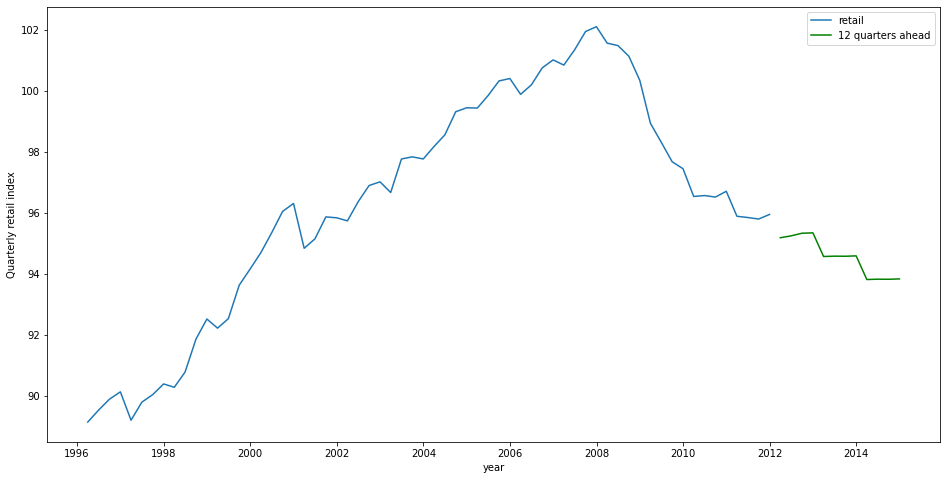

In [82]:
# predicting the next 12 values

predict_arima = eu_fit_r.forecast(steps=12)
predict_arima

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(eu_df.index, eu_df.retail.values, label='retail')
ax.plot(pd.date_range(start='31/1/2012',  periods=12, freq='Q'), predict_arima, color="green", label='12 quarters ahead')
plt.ylabel('Quarterly retail index') 
plt.xlabel('year') 
plt.legend();